# Algoritmos de Histograma de Gradientes Orientados (HOG) de Dalal y Triggs

## Librerias

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from scipy.signal import correlate2d

## Ejercicio 1

Implementar una función en Python que acepte una imagen a colores, y haga las siguientes transformaciones: 
- Conversión de RGB a escala de grises
- Reescalado (*resize*) a un tamaño (*128k,64k*), (ratio 2:1). 

En este caso **k ≥ 1** es un parámetro de escala que da el tamaño de la imagen de salida, y debe ser indicado por el usuario. La salida debe ser una imagen en formato 8 bits o float de tamaño (*128k, 64k*), esto es un numpy array de tamaño (*128k,64k*).

In [2]:
def preprocess_image(image, k=1):
    """
    Carga y preprocesa una imagen desde la ruta especificada.
    La imagen se convierte a escala de grises y se redimensiona a un tamaño específico.
    El tamaño de la imagen resultante es (128k, 64k) donde k es un factor de escala.
    
    Args:
        image (numpy.ndarray): Imagen de entrada en formato RGB.
        k (int): Factor de escala para redimensionar la imagen. Por defecto es 1.

    Returns:
        numpy.ndarray: Imagen preprocesada en formato float32.
    """ 
    # Verificar que k sea válido
    if k < 1:
        raise ValueError("k debe ser mayor o igual a 1")

    # Convertir a escala de grises
    gray_image = rgb2gray(image)  # devuelve una imagen en float64 [0, 1]

    # Redimensionar la imagen al tamaño (128k, 64k)
    new_size = (64 * k, 128 * k)  # (ancho, alto)
    resized_image = cv2.resize(gray_image, new_size, interpolation=cv2.INTER_AREA) # Cambiar el orden a (alto, ancho)

    # Convertir a float32 si se desea trabajar en precisión simple
    return resized_image.astype(np.float32)

### Prueba

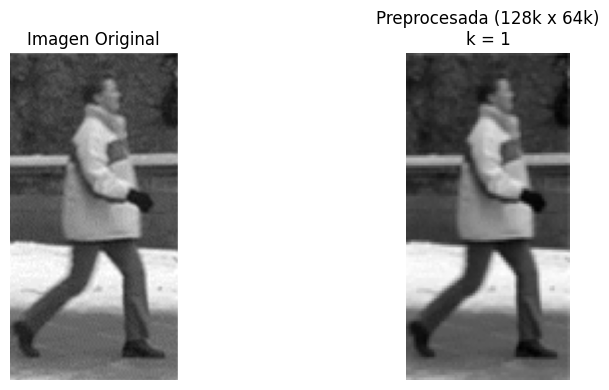

Imagen preprocesada de tamaño: (128, 64)


In [3]:
image = cv2.imread("Images/person.png") # Cargar la imagen

k = 1  # Factor de escala

processed = preprocess_image(image, k) # Preprocesar la imagen

# Mostrar la imagen original y la preprocesada
plt.figure(figsize=(10, 4))

# Mostrar la imagen original
plt.subplot(1, 2, 1)
plt.title('Imagen Original')
plt.imshow(image)
plt.axis('off')

# Mostrar la imagen preprocesada
plt.subplot(1, 2, 2)
plt.title(f'Preprocesada (128k x 64k)\nk = {k}')
plt.imshow(processed, cmap='gray')
plt.axis('off')

# Ajustar el espaciado entre subgráficas
plt.tight_layout()
plt.show()

print(f"Imagen preprocesada de tamaño: {processed.shape}")

## Ejercicio 2

Implementar una función en Python que calcule la **magnitud** y el **ángulo** del gradiente de una imagen en escala de grises. Internamente su algoritmo debe calcular las correlaciones  
$$ G_x = I * \nabla_x \quad y \quad G_y = I * \nabla_y $$

de la imagen con los **filtros de Prewitt**

$$
\nabla_x = 
\begin{bmatrix}
-1 & -1 & -1 \\
\phantom{-}0 & \phantom{-}0 & \phantom{-}0 \\
\phantom{-}1 & \phantom{-}1 & \phantom{-}1
\end{bmatrix}
\qquad
\nabla_y = 
\begin{bmatrix}
-1 & \phantom{-}0 & \phantom{-}1 \\
-1 & \phantom{-}0 & \phantom{-}1 \\
-1 & \phantom{-}0 & \phantom{-}1
\end{bmatrix}
$$

o **filtros de Sobel**

$$
\nabla_x = 
\begin{bmatrix}
-1 & -2 & -1 \\
\phantom{-}0 & \phantom{-}0 & \phantom{-}0 \\
\phantom{-}1 & \phantom{-}2 & \phantom{-}1
\end{bmatrix}
\qquad
\nabla_y = 
\begin{bmatrix}
-1 & \phantom{-}0 & \phantom{-}1 \\
-2 & \phantom{-}0 & \phantom{-}2 \\
-1 & \phantom{-}0 & \phantom{-}1
\end{bmatrix}
$$

(No olvidar hacer un *padding* adecuado en la imagen a filtrar, y dar una salida del mismo tamaño de la imagen de entrada).

En este caso la entrada es una imagen en escala de grises *I*. La salida de la funcion deben de ser dos imágenes `µ` y `θ` dadas por:


$$
\mu = \sqrt{G_x^2 + G_y^2} \quad y \quad \theta = \arctan2(-G_y, G_x) \cdot \left( \frac{180}{\pi} \right)
$$

ambas del mismo tamaño de la imagen de entrada *I*.

(Considerar que se debe hacer módulo 180 en la imagen `θ` para que el rango de los angulos obtenidos sea siempre 0 ≤ *θ* ≤ 180)

In [4]:
def compute_gradient(I, sobel=True):
    """
    Calcula la magnitud y ángulo del gradiente de una imagen en escala de grises.
    Utiliza filtros de Sobel o Prewitt según lo especificado.
    
    Args:
        I (numpy.ndarray): Imagen en escala de grises (float32 o float64).
        sobel (bool): True para usar Sobel, False para usar Prewitt.
    
    Returns:
        tuple: (magnitud mu, ángulo theta) ambos del mismo tamaño que I.
    """
    # Seleccionar el filtro según el parámetro 'sobel'
    if sobel:
        # Filtros de Sobel
        kernel_x = np.array([[-1, -2, -1],
                             [ 0,  0,  0],
                             [ 1,  2,  1]])
        kernel_y = np.array([[-1, 0, 1],
                             [-2, 0, 2],
                             [-1, 0, 1]])
    else:
        # Filtros de Prewitt
        kernel_x = np.array([[-1, -1, -1],
                             [ 0,  0,  0],
                             [ 1,  1,  1]])
        kernel_y = np.array([[-1, 0, 1],
                             [-1, 0, 1],
                             [-1, 0, 1]])

    # Correlaciones con padding para mantener el tamaño
    Gx = correlate2d(I, kernel_x, mode='same', boundary='symm')
    Gy = correlate2d(I, kernel_y, mode='same', boundary='symm')

    # Magnitud del gradiente
    mu = np.sqrt(Gx ** 2 + Gy ** 2)

    # Ángulo en grados, normalizado a [0, 180)
    theta = np.arctan2(-Gy, Gx) * (180.0 / np.pi)
    theta = np.mod(theta, 180.0)

    # Retornar magnitud y ángulo como float32
    return mu.astype(np.float32), theta.astype(np.float32)

### Prueba

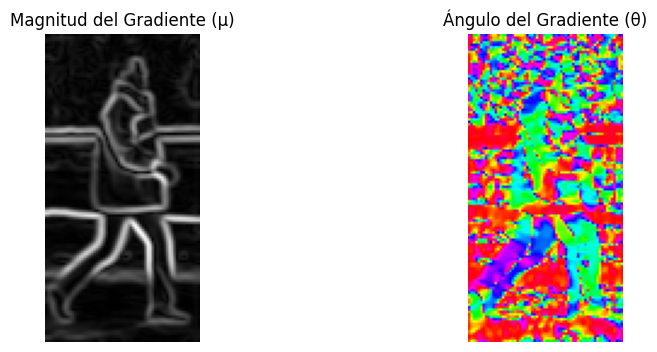

mu shape: (128, 64)
theta shape: (128, 64)


In [5]:
# Obtener la imagen preprocesada en escala de grises
gray_image = preprocess_image(image, k=k)

# Aplicar suavizado a la imagen para reducir ruido antes del gradiente
gray_image = cv2.GaussianBlur(gray_image, (3, 3), sigmaX=1)

# Calcular gradientes
mu, theta = compute_gradient(gray_image, sobel=True)

# Mostrar la magnitud del gradiente
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Magnitud del Gradiente (μ)")
plt.imshow(mu, cmap='gray')
plt.axis('off')

# Mostrar el ángulo del gradiente
plt.subplot(1, 2, 2)
plt.title("Ángulo del Gradiente (θ)")
plt.imshow(theta, cmap='hsv')
plt.axis('off')
plt.show()

# Confirmar tamaños
print("mu shape:", mu.shape)
print("theta shape:", theta.shape)

## Ejercicio 3

Implementar una función en Python que construya el stack de bloques de tamaño `block_size x block_size`, usando un `stride` de `block_size//2`. En este caso, `block_size` debe ser un parámetro indicado por el usuario (se sugiere que sea un múltiplo de 4, e.g. 4x4, 8x8, 16x16).

La entrada de la función debe ser la imagen `μ` y `θ` obtenidas del gradiente anterior, y su función debe devolver dos stack o `numpy arrays` de tamaño:

$$
MN \times \text{block\_size} \times \text{block\_size}
$$

Uno para la **magnitud** y otro para el **ángulo** del gradiente.  
Aquí:

$$
M = \left(\frac{128k}{\text{stride}}\right) - 1, \quad N = \left(\frac{64k}{\text{stride}}\right) - 1
$$

In [6]:
def extract_blocks(mu, theta, block_size=8, stride=None):
    """
    Construye un stack de bloques (mu y theta) a partir de las matrices de gradiente.
    
    Args:
        mu (ndarray): Matriz de magnitud del gradiente (shape: H x W).
        theta (ndarray): Matriz de ángulo del gradiente (shape: H x W).
        block_size (int): Tamaño del bloque cuadrado (debe ser múltiplo de 4).
        stride (int): Desplazamiento entre bloques. Si es None, se calcula como block_size // 2.
    
    Returns:
        tuple: (stack_mu, stack_theta, M, N) donde:
            - stack_mu: Stack de bloques de magnitud del gradiente.
            - stack_theta: Stack de bloques de ángulo del gradiente.
            - M: Número de bloques en la dirección vertical.
            - N: Número de bloques en la dirección horizontal.
    """
    # Verificar que el tamaño del bloque sea múltiplo de 4
    
    if block_size % 4 != 0:
        raise ValueError("El tamaño del bloque debe ser múltiplo de 4")
    
    # Obtener dimensiones de la imagen
    H, W = mu.shape

    # Verificar si se da el stride, si no se da, se calcula como block_size // 2
    if stride is None:
        stride = block_size // 2 # Desplazamiento por defecto
        M = (H // stride) - 1
        N = (W // stride) - 1
    else:
        # Si se da el stride, se calcula M y N
        # M y N son el número de bloques en la dirección vertical y horizontal respectivamente
        M = (H - block_size) // stride + 1
        N = (W - block_size) // stride + 1

    # Inicializar stacks para mu y theta
    # El tamaño de stack_mu y stack_theta es (M*N, block_size, block_size)
    stack_mu = np.zeros((M * N, block_size, block_size), dtype=np.float32)
    stack_theta = np.zeros_like(stack_mu)

    # Extraer bloques de mu y theta
    index = 0
    for i in range(M):
        for j in range(N):
            # Calcular el índice de inicio para el bloque actual
            # stride es el desplazamiento entre bloques
            start_i = i * stride
            start_j = j * stride

            # Calcular el bloque de mu y theta 
            block_mu = mu[start_i:start_i + block_size, start_j:start_j + block_size]
            block_theta = theta[start_i:start_i + block_size, start_j:start_j + block_size]

            # Verificar que el bloque tenga el tamaño correcto
            # Si el bloque tiene el tamaño correcto, se agrega al stack
            if block_mu.shape == (block_size, block_size):
                stack_mu[index] = block_mu
                stack_theta[index] = block_theta
                index += 1
            # Si no tiene el tamaño exacto, se ignora el bloque

    # Retornar los stacks de bloques
    return stack_mu, stack_theta, M, N

### Prueba

In [7]:
block_size = 8 # Tamaño del bloque
stack_mu, stack_theta, M, N = extract_blocks(mu, theta, block_size=block_size, stride=block_size) # Extraer bloques

# Mostrar el tamaño de los stacks
print("Shape de stack_mu:", stack_mu.shape)
print("Shape de stack_theta:", stack_theta.shape)

Shape de stack_mu: (128, 8, 8)
Shape de stack_theta: (128, 8, 8)


## Ejercicio 4

Implementar una función en Python que construya el histograma de gradientes, a partir de los stacks de bloques `μ` y `θ`. La construcción del histograma debe recibir un número de **bines `n`** indicado por el usuario (se sugiere usar `n = 9`). Internamente la función deberá calcular los centros de cada bin, y hacer un barrido de cada uno de los bloques en los stacks. Para cada bloque, debe calcularse un vector (numpy array de tamaño `n`) donde se guardará la información de su respectivo histograma.

Para el proceso o cálculo de los votos y la construcción del histograma.
Cada píxel $(x,y)$ del bloque contribuye un voto al correspondiente bin de su orientación $θ(x,y)$, *pesada por la magnitud* $μ(x,y)$. El cálculo se hará siguiendo el método de **interpolación bilineal**.

1. Suponga que $θ(x,y)$ yace entre dos bines $b_1$ y $b_2$. Se calculan los pesos:

$$
w_1 = \frac{|b_2 - θ(x,y)|}{\text{bin width}}, \quad
w_2 = \frac{|θ(x,y) - b_1|}{\text{bin width}}
$$

Aquí $b_1$ y $b_2$ son los dos bines adyacentes a $θ(x,y)$.


1. Distribuir los votos correspondientes al píxel $(x,y)$ en los dos bines $b_1$ y $b_2$ de manera proporcional a los pesos. Primero asegúrese que los pesos suman 1 $(w_1 + w_2 = 1)$, y luego hacer:

$$
\text{hist}[b_1] += w_1 \cdot μ(x,y), \quad
\text{hist}[b_2] += w_2 \cdot μ(x,y)
$$

La salida de la función debe ser un `numpy array` $H$ de tamaño $MN \times n$ con la información de cada histograma. Los histogramas deberán normalizarse utilizando la **norma euclideana**:
$$
\text{hist}[b_i] = \frac{\text{hist}[b_i]}{\sqrt{||\text{hist}[b_i]||^2 + \varepsilon}}
$$

In [8]:
def compute_histograms(stack_mu, stack_theta, n_bins=9, epsilon=1e-6):
    """
    Calcula el histograma de orientaciones para cada bloque usando interpolación bilineal.

    Args:
        stack_mu (ndarray): Magnitudes por bloque, shape (MN, block_size, block_size)
        stack_theta (ndarray): Ángulos por bloque, shape (MN, block_size, block_size)
        n_bins (int): Número de bines del histograma (e.g. 9)
        epsilon (float): Valor pequeño para evitar división por cero al normalizar

    Returns:
        H_out (ndarray): Histograma normalizado por bloque, shape (MN, n_bins)
    """
    # Obtener dimensiones de los stacks
    MN, H, W = stack_mu.shape
    
    # Obtener el ancho de los bines y los centros de los bines
    bin_width = 180 / n_bins
    bin_centers = np.linspace(bin_width / 2, 180 - bin_width / 2, n_bins)

    # Inicializar el histograma de salida
    H_out = np.zeros((MN, n_bins), dtype=np.float32)

    # Recorrer cada bloque y calcular el histograma
    for idx in range(MN):
        # Inicializar el histograma para el bloque actual
        hist = np.zeros(n_bins, dtype=np.float32)

        # Obtener el bloque de magnitudes y ángulos
        for i in range(H):
            for j in range(W):
                theta = stack_theta[idx, i, j]
                mu = stack_mu[idx, i, j]

                # Encontrar los dos bines más cercanos
                bin_index = theta / bin_width
                b1 = int(np.floor(bin_index)) % n_bins
                b2 = (b1 + 1) % n_bins

                # Centros de bines b1 y b2
                b1_center = bin_centers[b1]
                b2_center = bin_centers[b2]

                # Calcular pesos (interpolación lineal)
                w1 = abs(b2_center - theta) / bin_width
                w2 = abs(theta - b1_center) / bin_width
                w_sum = w1 + w2

                # Normalizar pesos
                if w_sum > 0:
                    w1 /= w_sum
                    w2 /= w_sum

                # Acumular votos
                hist[b1] += w1 * mu
                hist[b2] += w2 * mu

        # Normalización L2 (Euclideana)
        norm = np.sqrt(np.sum(hist ** 2) + epsilon)
        hist /= norm

        # Agregar el histograma normalizado al resultado
        H_out[idx] = hist

    return H_out

### Prueba

In [9]:
# Obtener el histograma de orientaciones para cada bloque
H = compute_histograms(stack_mu, stack_theta, n_bins=9)

# Mostrar el tamaño del histograma final
print("Shape del histograma final:", H.shape)  # (MN, n)

Shape del histograma final: (128, 9)


## Ejercicio 5

Escribir una función en Python que, a cada bloque en el stack, convierta el histograma de ese bloque a una representación visual. Esta representación visual será una matriz de tamaño `block_size × block_size`. Esta imagen se trabaja como una **imagen con fondo negro**. Por cada índice en el histograma de dicho bloque, $i = 1, 2, ..., n$, se dibujará una **línea con ángulo en el centroide $C_i$** del bin $i$, y de **magnitud o intensidad igual al valor del histograma en el bin $i$**.


Construir una **imagen de direcciones** que dibuje los histogramas visuales de cada bloque. (Aquí se sugiere usar un `block_size = 8` y un `stride = block_size = 8`).

Generar una visualización similar a:

![Visualización HOG](Images/example_hog.png)

In [10]:
def draw_block_histogram(hist, block_size=8, n_bins=9):
    """
    Dibuja una imagen visual de tamaño block_size x block_size para un histograma de gradientes.
    Las líneas se escalan proporcionalmente a la magnitud del bin (sin threshold agresivo).

    Args:
        hist (ndarray): Histograma de tamaño (n_bins,)
        block_size (int): Tamaño del bloque (e.g. 8)
        n_bins (int): Número de bines

    Returns:
        image (ndarray): Imagen 2D en escala de grises del bloque visual
    """
    bin_width = 180 / n_bins
    center = block_size // 2
    max_len = block_size // 2 - 1  # longitud máxima de línea

    image = np.zeros((block_size, block_size), dtype=np.float32)

    for i in range(n_bins):
        if hist[i] < 0.05:
            continue
        angle = np.deg2rad(i * bin_width + bin_width / 2)

        # Escalar la longitud según la magnitud del histograma
        length = hist[i] * max_len
        dx = np.cos(angle) * length
        dy = np.sin(angle) * length

        x1 = int(round(center - dx))
        y1 = int(round(center - dy))
        x2 = int(round(center + dx))
        y2 = int(round(center + dy))

        # Dibujar la línea con intensidad proporcional
        cv2.line(image, (x1, y1), (x2, y2), color=float(hist[i]), thickness=1)

    return image


In [11]:
def build_visualization(H, block_size=8, grid_shape=None, n_bins=9):
    """
    Construye la imagen visual completa de direcciones a partir de los histogramas por bloque.

    Args:
        H (ndarray): Histograma por bloque, shape (M*N, n_bins)
        block_size (int): Tamaño de bloque (e.g. 8)
        grid_shape (tuple): (M, N) número de bloques en alto y ancho
        n_bins (int): Número de bines por histograma

    Returns:
        full_image (ndarray): Imagen final en escala de grises con visualización de orientaciones
    """
    if grid_shape is None:
        M = N = int(np.sqrt(len(H)))
    else:
        M, N = grid_shape

    H_img = np.zeros((M * block_size, N * block_size), dtype=np.float32)

    for idx, hist in enumerate(H):
        i = idx // N
        j = idx % N
        block_img = draw_block_histogram(hist, block_size, n_bins)
        H_img[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = block_img

    # Escalar la imagen para mejor visualización (opcional)
    if H_img.max() > 0:
        H_img /= H_img.max()

    return H_img


### Prueba

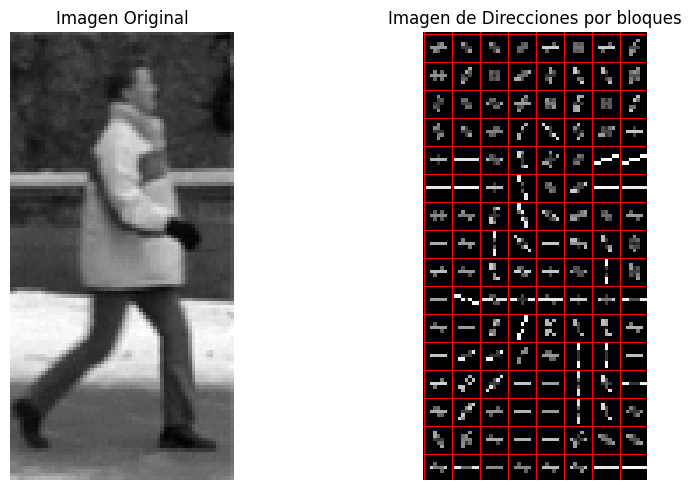

In [12]:
# Construir la imagen de direcciones a partir de los histogramas
visual_image = build_visualization(H, block_size=block_size, grid_shape=(M, N))

# Mostrar junto a la imagen original
plt.figure(figsize=(10, 5))

# Imagen original
plt.subplot(1, 2, 1)
plt.title("Imagen Original")
plt.imshow(processed, cmap='gray')
plt.axis('off')

# Imagen de direcciones
plt.subplot(1, 2, 2)
plt.title("Imagen de Direcciones por bloques")
plt.imshow(visual_image, cmap='gray')

# Dibujar líneas de cuadrícula (opcional para visualización)
for y in range(0, visual_image.shape[0], block_size):
    plt.axhline(y=y, color='red', linewidth=0.8)
for x in range(0, visual_image.shape[1], block_size):
    plt.axvline(x=x, color='red', linewidth=0.8)

plt.axis('off')
plt.tight_layout()
plt.show()


## Ejercicio 6

Comparar sus resultados del algoritmo anterior (Ejercicios 1 a 5), contra la función de scikit-image hog. 
```python
    from skimage.feature import hog 
    fd, hogI = hog(I, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True).

    plt.figure() 
    plt.imshow(hogI) 
    plt.show()
```

In [13]:
from skimage.feature import hog

# Calcular HOG con scikit-image
fd, hogI = hog(
    processed,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True,
    feature_vector=True
)

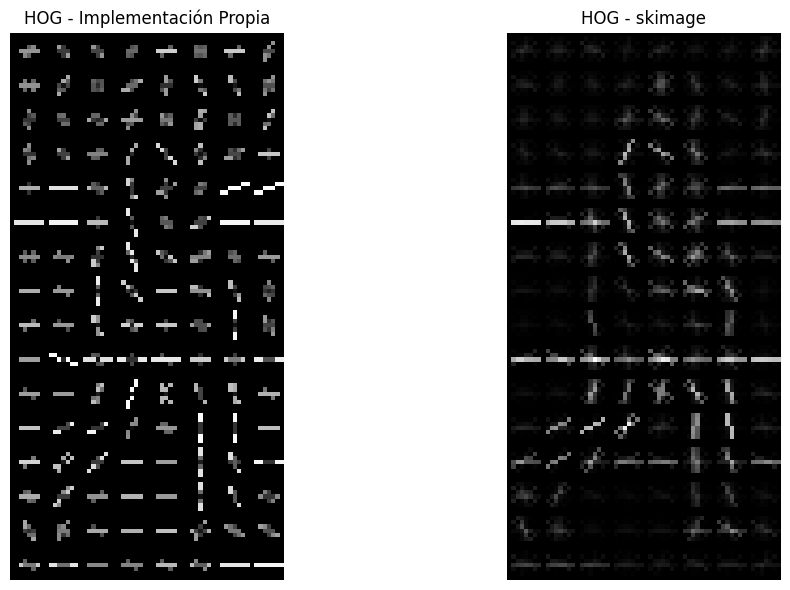

In [14]:
# Comparación de la implementación propia con la de skimage
plt.figure(figsize=(12, 6))

# Implementación propia from scratch
plt.subplot(1, 2, 1)
plt.title("HOG - Implementación Propia")
plt.imshow(visual_image, cmap='gray')
plt.axis('off')

# Implementación de skimage 
plt.subplot(1, 2, 2)
plt.title("HOG - skimage")
plt.imshow(hogI, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

### Comparación
La comparación entre ambas representaciones de HOG muestra diferencias en la distribución y visualización de los gradientes. En la implementación propia (izquierda), los gradientes aparecen con mayor contraste y segmentación, con bloques bien diferenciados y líneas más marcadas. En cambio, la implementación de skimage (derecha) presenta una visualización más suavizada y difusa, con una mayor continuidad en los bordes. Esto puede deberse a diferencias en los parámetros utilizados, como el tamaño de celdas y bloques, el método de normalización o la interpolación de los histogramas de gradientes. Además, la forma en que cada método representa la orientación y magnitud de los gradientes podría estar influyendo en la nitidez y estructura de la imagen resultante.

## Ejercicio 7

Implementar un método de deteccion de personas, utilizando la librerıa de OpenCV. Mostrar resultados de su deteccion con diferentes imagenes de su eleccion.

```python
    import cv2
    hog2 = cv2.HOGDescriptor()
    hog2.setSVMDetector(cv2.HOGDescriptor getDefaultPeopleDetector())
    locations, confidence = hog2.detectMultiScale(I)
    for (x, y, w, h) in locations:
    cv2.rectangle(I, (x, y), (x + w, y + h), (0, 0, 255), 5)
    I rgb = cv2.cvtColor(I, cv2.COLOR BGR2RGB)
    plt.figure(figsize=(20,10))
    plt.imshow(I rgb)
    plt.axis(’off’)
    plt.show()
```

*Note* Para correr este codigo se necesita del modelo `yolov4.cfg`. Para esto descargar estos dos archivos, colocarlos en un folder llamado `models`. Y correr el código.

### Archivos:
- https://github.com/Tianxiaomo/pytorch-YOLOv4/blob/master/cfg/yolov4.cfg
- https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwj7naDrj7yMAxVPRzABHW61NnUQFnoECBgQAQ&url=https%3A%2F%2Fgithub.com%2FAlexeyAB%2Fdarknet%2Freleases%2Fdownload%2Fdarknet_yolo_v3_optimal%2Fyolov4.weights&usg=AOvVaw30if4joxtTaS8DAh12vYQ4&opi=89978449


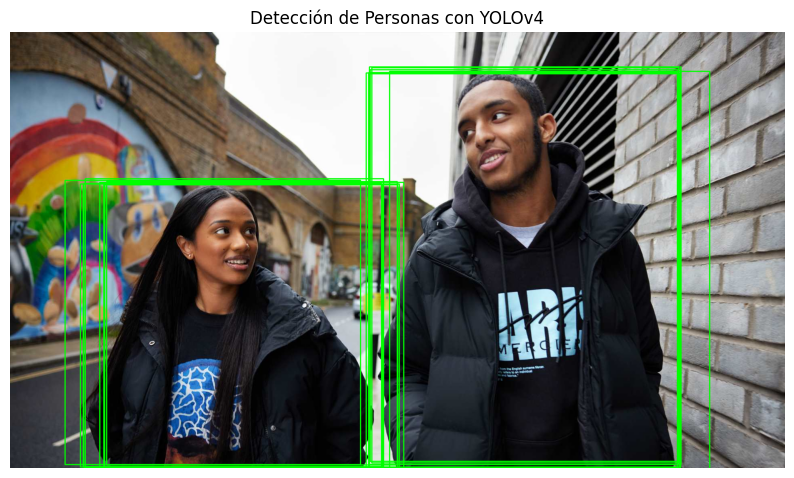

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Cargar modelo YOLOv4 preentrenado
yolo_net = cv2.dnn.readNet("models/yolov4.weights", "models/yolov4.cfg")
layer_names = yolo_net.getLayerNames()
output_layers = [layer_names[i - 1] for i in yolo_net.getUnconnectedOutLayers()]

# Cargar imagen
image_path = "Images/imagen1.jpg"
I = cv2.imread(image_path)

if I is None:
    raise ValueError("No se pudo cargar la imagen. Verifica la ruta.")

height, width = I.shape[:2]

# Preprocesamiento para YOLO
blob = cv2.dnn.blobFromImage(I, 1/255.0, (416, 416), swapRB=True, crop=False)
yolo_net.setInput(blob)
detections = yolo_net.forward(output_layers)

# Procesar detecciones
for output in detections:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]

        # Solo mostrar detecciones con alta confianza (mayor a 50%)
        if confidence > 0.5 and class_id == 0:  # ID 0 es 'persona' en COCO dataset
            center_x, center_y, w, h = (detection[:4] * np.array([width, height, width, height])).astype("int")
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            cv2.rectangle(I, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Convertir a RGB para mostrar con Matplotlib
I_rgb = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)

# Mostrar imagen con detecciones
plt.figure(figsize=(10, 6))
plt.imshow(I_rgb)
plt.axis("off")
plt.title("Detección de Personas con YOLOv4")
plt.show()

Se hace uso de un modelo de redes neuronales preentrenado para mejorar la detección de múltiples personas, y múltiples angulos, no importando si solo salen sus rostros o todo el cuerpo.

### Recomendaciones
- Se recomienda el mejoramiento de los cuadros que detectan a la persona, ya que presentan varios y puede ser confuso.
- Se pueden utilizar otros modelos preentrenados para comparar el desempeño, tales como `SSD MobileNet` o `Faster R-CNN`. 